# Airbus Ship Detection dataset exploration

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# seaborn plot style
sns.set(style="darkgrid")

# System paths
root_dir = "/media/davidtvs/Storage/Datasets/airbus-ship-detection"
trainset_dir = os.path.join(root_dir, "train_v2")
testset_dir = os.path.join(root_dir, "test_v2")
train_rle = os.path.join(root_dir, "train_ship_segmentations_v2.csv")

## Dataset size

In [2]:
print("Number of images in train folder:", len(os.listdir(trainset_dir)))
print("Number of images in test folder:", len(os.listdir(testset_dir)))

Number of images in train folder: 192556
Number of images in test folder: 15606


## Image sizes

The following code cell takes longer than 30 min to run. The goal was to verify that the images all have the same size, and they do.

Image resolution: (768, 768)

In [3]:
#def get_image_sizes(image_dir):
#    image_sizes = []
#    for file in os.listdir(image_dir):
#        filepath = os.path.join(image_dir, file)
#        with Image.open(filepath, mode='r') as img:
#            image_sizes.append(img.size)
#            
#    return image_sizes
#
#train_sizes = get_image_sizes(trainset_dir)
#test_sizes = get_image_sizes(testset_dir)
#print("Image resolutions in the training set:", pd.unique(train_sizes))
#print("Image resolutions in the test set:", pd.unique(test_sizes))

## Ships distribution in images

The ground-truth segmentations are encoded in run-length format:
 - Each row defines the segmentation for a single ship
 - Images with n ships have n rows
 - Images without ships have one row with NaN as the value
 - The encoding format is a list of (start length) pairs in pixels

In [4]:
# Run length encoding CSV
rle_df = pd.read_csv(train_rle)
rle_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
# Images with n ships have n rows
unique_rle_df = rle_df.drop_duplicates('ImageId')
num_images = len(unique_rle_df)
print("Number of images in run length encoding CSV:", num_images)

Number of images in run length encoding CSV: 192556


In [6]:
# Images without ships have EncodedPixels set to NaN
images_with_ships = unique_rle_df.dropna(subset=['EncodedPixels'])
num_images_with_ships = len(images_with_ships)
num_images_wo_ships = len(unique_rle_df) - len(images_with_ships)
print("Number of images with ships: {0} ({1:.1f}%)".format(num_images_with_ships, (num_images_with_ships / num_images) * 100))
print("Number of images without ships: {0} ({1:.1f}%)".format(num_images_wo_ships, (num_images_wo_ships / num_images) * 100))

Number of images with ships: 42556 (22.1%)
Number of images without ships: 150000 (77.9%)


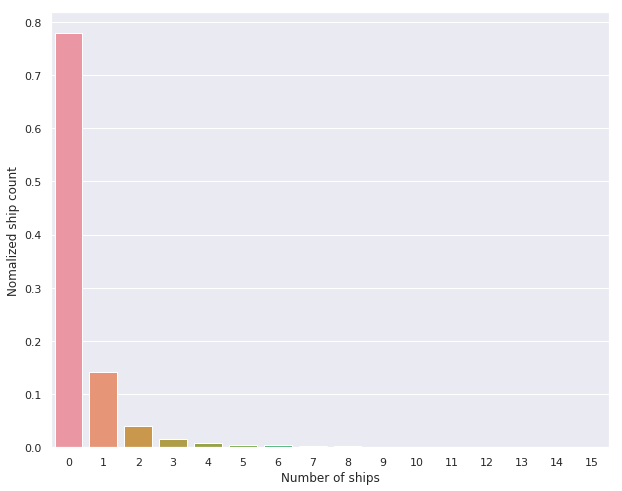

In [7]:
ship_count_df = rle_df.groupby('ImageId').count().reset_index().rename(columns={"EncodedPixels": "ShipCount"})
ship_dist = ship_count_df.groupby('ShipCount')['ShipCount'].agg('count')
ship_dist = ship_dist / sum(ship_dist)
fig = plt.figure(figsize=(10, 8))
g = sns.barplot(x=ship_dist.index, y=ship_dist.values)
_ = g.set_ylabel("Nomalized ship count")
_ = g.set_xlabel("Number of ships")

The dataset is very imbalanced. Only 22% of the images have ships and most of those have only one ship.

## Ships distribution in pixels

The situation only gets worse if we go down to the pixel-level

In [8]:
def rle_pixel_count(rle):
    count = 0
    if not pd.isna(rle):
        rle_split = rle.split()
        for value in rle_split[1::2]:
            count += int(value)
    
    return count

rle_df['PixelCount'] = rle_df['EncodedPixels'].apply(rle_pixel_count)
total_ship_pixels = sum(rle_df['PixelCount'])
total_pixels = 768 * 768 * num_images
print("Percentage of ship-pixels: {0:.3f}%".format((total_ship_pixels / total_pixels) * 100))

Percentage of ship-pixels: 0.113%


Only 0.1% of the pixels belong to the ship class, the remaining are background. If we discard the images that don't have ships the situation improves slightly

In [9]:
total_pixels = 768 * 768 * num_images_with_ships
print("Percentage of ship-pixels: {0:.3f}%".format((total_ship_pixels / total_pixels) * 100))

Percentage of ship-pixels: 0.510%
